In [3]:
import numpy as np
import cv2
import PIL
from matplotlib import pyplot as plt
import os
from os import listdir


In [9]:
folder_dir = "Shirts/"
for images in os.listdir(folder_dir)[1:]:
    img = cv2.imread(os.path.join("Shirts/", images)) #change dataset of shirts here
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 15)
    blur2 = cv2.medianBlur(gray, 75)

    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
    sharpen2 = cv2.filter2D(blur2, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 160, 255, cv2.THRESH_BINARY_INV)[1]
    thresh2 = cv2.threshold(sharpen2, 160, 255, cv2.THRESH_BINARY_INV)[1]
    thresh2 = cv2.medianBlur(thresh2, 9)
    
    
    #mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    h, w, c = img.shape
    
    f = 0
    b = 1
    if thresh[2,2,] == 0:
        f = 1
        b = 0
    
    mask = np.where((thresh==0)|(thresh==2), f, b).astype('uint8')
    mask2 = np.where((thresh2==0)|(thresh2==2), f, b).astype('uint8')
    mask3 = np.multiply(mask,mask2)
    outline = 255*mask[:,:,np.newaxis]
    cv2.imwrite(os.path.join("Outlines/" , "outline_"+images), outline)
    
    cv2.floodFill(outline, None,(0,0),100)
    cv2.floodFill(outline, None,(w-1,h-1),100)
    cv2.floodFill(outline, None,(0,h-1),100)
    cv2.floodFill(outline, None,(w-1,0),100)

    mask2 = 255*mask2[:,:]
    blueArticles = outline
    blurArticles = np.where(outline == 255, mask2[:,:,np.newaxis], outline).astype('uint8')    
        
    #components = np.where(outline == 0, b, f).astype('uint8')
    
    cv2.imwrite(os.path.join("Extracted_Shirts/" , "Extracted_"+images), blurArticles)
    
    #img = img*mask2[:,:,np.newaxis]
    #cv2.grabCut(img, outline,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    
    #filename = "extracted_"+images
    #cv2.imwrite(os.path.join("Extracted_Shirts/" , filename), img) #Change extracted shirt folder here
    cpy = blurArticles
    
    midw = (w//2)
    t4h = (h//2)
    lBound = 0
    while (blurArticles[t4h, lBound] != 0): #checked l and t bounds
        #cpy[t4h,lBound] = 255
        lBound = lBound + 1
    rBound = w-1
    while blurArticles[t4h, rBound] != 0:
        #cpy[t4h, rBound] = 255
        rBound = rBound - 1
    tBound = 0
    while blurArticles[tBound, midw] != 0:
        #cpy[tBound, midw] = 255
        tBound = tBound + 1
    bBound = h-1
    while blurArticles[bBound, midw] != 0:
        #cpy[bBound, midw] = 255
        bBound = bBound - 1
        
    lB = rBound-10 
    rB = lBound+10
    uB = bBound-10  
    bB = tBound+10 
    #cv2.imwrite(os.path.join("Extracted_Shirts/" , "Help"+images), cpy)
    #print(uB)
    #print(bB)
    hasComp = False
    for y in range(tBound+h//20, bBound-h//20):
        for x in range(lBound+w//20, rBound-w//20):
            if(blurArticles[y,x] == 255): #blurArticles(height, width)
                hasComp = True
                lB = min(lB, x)
                rB = max(rB, x)
                uB = min(uB, y)
                bB = max(bB, y)

    if hasComp:
        bw = w//20
        bh = h//20
        component = img[uB-bh:bB+bh, lB-bw:rB+bw]
        cv2.imwrite(os.path.join("Components/" , "component_"+images), component)
                
    
    
    

In [8]:
#Code to combine Shirts
mainShirt = PIL.Image.open("Shirts/Red_Shirt.jpg")
subShirt = PIL.Image.open("Shirts/tshirt2.jpg")
comp = PIL.Image.open("Components/Component_tshirt2.jpg")

fx = mainShirt.width/subShirt.width
fy = mainShirt.height/subShirt.height
nw = (int) (fx*comp.width)
nh = (int) (fy*comp.height)
comp = comp.resize((nw,nh))

center = (mainShirt.width//2, mainShirt.height//2)
ploc = (center[0] - nw//2, center[1] - nh//2)
mainShirt.paste(comp, ploc)
mainShirt.save("MyShirt.jpg", quality=100)



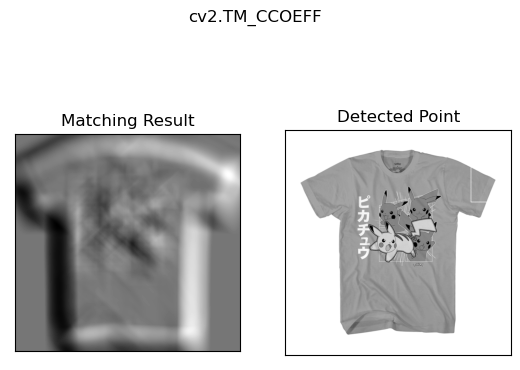

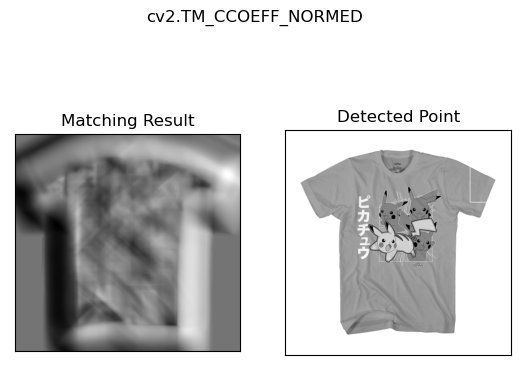

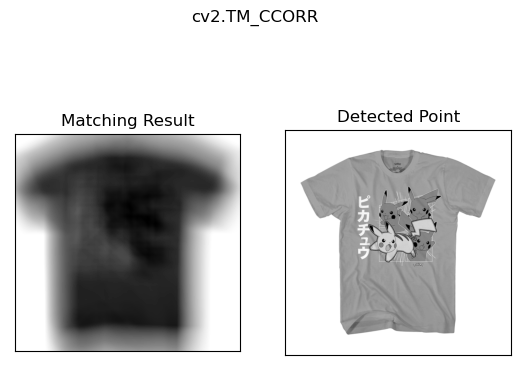

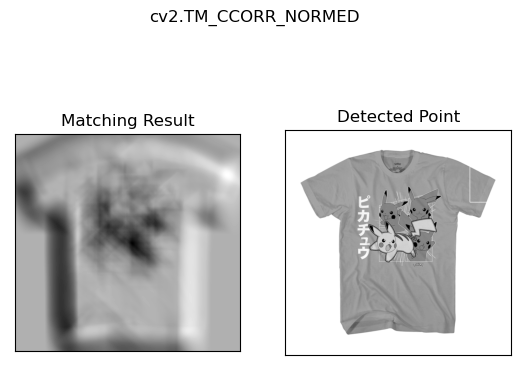

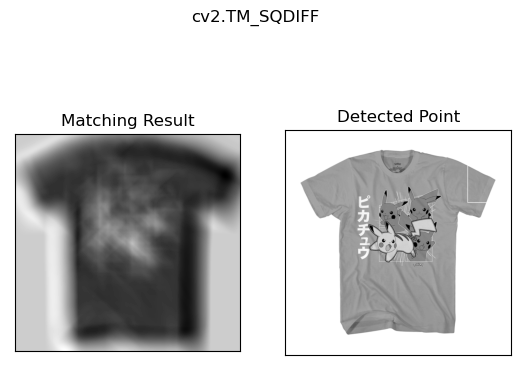

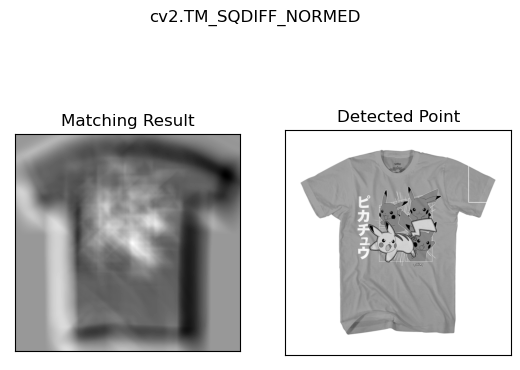

In [6]:
img = cv2.imread("Shirts/pokemon_shirt.png",0)
img2 = img.copy()
template = cv2.imread('Popular_Comp/Red_Shirt_Sleeve.jpg',0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()